<div align="center">
  <h1></h1>
  <h1>Universidad Nacional de Colombia</h1>
  <h2>Procesamiento del lenguaje natural</h2>
  <h2>Proyecto</h2>
  <h2>Dr Diomedes:
  <h3>Un Bot con sentimiento</h3>
  <h3>Grupo 1</h3>
  <strong>Estudiantes:</strong>  <br>
  Jhojan Sebastian Arango Castillo (<a href="mailto:jsarangoca@unal.edu.co">jsarangoca@unal.edu.co</a>) <br>
  Diego Andres Benitez Duarte (<a href="mailto:dabenitezd@unal.edu.co">dabenitezd@unal.edu.co</a>) <br>
  Jeraldine Muñoz Alvarado (<a href="mailto:jemunozal@unal.edu.co">jemunozal@unal.edu.co</a>) <br>
  Johan Sebastian Suarez Sepulveda (<a href="mailto:jemunozal@unal.edu.co">jssuarezse@unal.edu.co</a>) <br>
  <strong>Profesora:</strong> Elizabeth León Guzmán
</div>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df2 = pd.read_excel("/content/data.xlsx")

In [ ]:
df2.head(5)

,nombre_cancion,frase,sentimiento_predicho,sentimiento_emocional
0,26 de mayo,el veintiséis del mes de mayo,neutral,descriptivo
1,A mi papá,voy a componé un merengue,neutral,descriptivo
2,A un cariño del alma,cuando se acaban todas las palabras,negativo,resignado
3,A un colega,de una manera especial y en una forma correcta,neutral,descriptivo
4,A Un Ladito Del Camino,hoy me siento enamorado,positivo,amoroso


In [ ]:
df = df2.sort_values(by='nombre_cancion').reset_index(drop=True)
display(df.head())

,nombre_cancion,frase,sentimiento_predicho,sentimiento_emocional
0,26 de mayo,el veintiséis del mes de mayo,neutral,descriptivo
1,26 de mayo,que renovaran su edad,neutral,descriptivo
2,26 de mayo,y hoy se conoce con el nombre de diomedes,neutral,descriptivo
3,26 de mayo,y se volvieran a enamorar,positivo,amoroso
4,26 de mayo,y al poco tiempo naciera yo nuevamente,neutral,reflexivo


In [ ]:
df['nombre_cancion'].nunique(), df.shape

(420, (17121, 4))

#1. Preprocesamiento del texto

Antes de que cualquier modelo de machine learning pueda "entender" el texto, debemos limpiarlo y estandarizarlo. Este proceso, conocido como preprocesamiento, es crucial para eliminar el "ruido" que podría confundir al algoritmo. En esta sección, definimos una función que realiza las siguientes tareas:

- **Convertir a minúsculas:** Unifica el texto para que palabras como "Amor" y "amor" sean tratadas por igual.
- **Eliminar puntuación y números:** Se remueven caracteres que generalmente no aportan valor semántico para la clasificación de sentimientos.
- **Quitar stopwords:** Se eliminan palabras muy comunes en español (como "el", "de", "que") que no suelen aportar información relevante. Hemos personalizado esta lista para conservar algunas palabras clave con carga afectiva como "nunca" o "siempre".
- **Normalizar espacios:** Se eliminan espacios extra para un formato consistente.

Aplicamos esta función a cada frase, creando una nueva columna `frase_limpia` que contendrá el texto listo para ser procesado.

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import nltk

# Descargar stopwords en español (solo la primera vez)
nltk.download('stopwords')

# Creamos una lista de stopwords base en español
stop_words = set(stopwords.words('spanish'))

# Opcional: eliminar algunas palabras que sí tienen valor afectivo
palabras_relevantes = {'más', 'menos', 'nunca', 'siempre', 'nadie', 'nada'}
stop_words = stop_words - palabras_relevantes

def limpiar_texto(texto):
    # Si el valor no es string, lo convierte en cadena vacía
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()                                 # minúsculas
    texto = re.sub(f"[{string.punctuation}]", "", texto)  # quitar signos
    texto = re.sub(r"\d+", "", texto)                     # quitar números
    texto = re.sub(r"\s+", " ", texto).strip()            # espacios múltiples
    palabras = [p for p in texto.split() if p not in stop_words]
    return " ".join(palabras)

# Aplicar a la columna
df['frase_limpia'] = df['frase'].apply(limpiar_texto)

display(df[['frase', 'frase_limpia']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,frase,frase_limpia
0,el veintiséis del mes de mayo,veintiséis mes mayo
1,que renovaran su edad,renovaran edad
2,y hoy se conoce con el nombre de diomedes,hoy conoce nombre diomedes
3,y se volvieran a enamorar,volvieran enamorar
4,y al poco tiempo naciera yo nuevamente,tiempo naciera nuevamente


In [ ]:
df[df['frase'].apply(lambda x: not isinstance(x, str))]

,nombre_cancion,frase,sentimiento_predicho,sentimiento_emocional,frase_limpia
5789,El tropezon,NaN,neutral,reflexivo,
16213,Un Ramito de Olivo,NaN,neutral,reflexivo,


In [ ]:
df = df.dropna(subset=['frase'])

# Vectorización TF-IDF

Los modelos de machine learning no trabajan con palabras, sino con números. Por lo tanto, necesitamos convertir nuestras frases limpias en vectores numéricos. Para ello, usamos la técnica **TF-IDF (Term Frequency-Inverse Document Frequency).**

TF-IDF es una medida que evalúa qué tan relevante es una palabra en un documento (en nuestro caso, una frase) en relación con el conjunto completo de documentos. Asigna un peso mayor a las palabras que son frecuentes en una frase pero raras en el resto, ayudando al modelo a identificar los términos más distintivos para cada categoría de sentimiento. Aquí configuramos el vectorizador para que considere tanto palabras individuales como pares de palabras consecutivas (`ngram_range=(1,2)`), lo que le permite capturar un poco más de contexto.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=2
)

X = vectorizer.fit_transform(df['frase_limpia'])
y = df['sentimiento_predicho']

print("Shape del vector TF-IDF:", X.shape)

Shape del vector TF-IDF: (17119, 11332)


In [ ]:
print("Tipo:", type(X))
print("Forma:", X.shape)
print("Número de features:", len(vectorizer.get_feature_names_out()))

Tipo: <class 'scipy.sparse._csr.csr_matrix'>
Forma: (17119, 11332)
Número de features: 11332


#Entrenamiento

Esta es la fase central donde construiremos y evaluaremos nuestros modelos de clasificación. El primer paso es dividir nuestro conjunto de datos vectorizados en dos subconjuntos:

- **Conjunto de entrenamiento** (`X_train`, `y_train`): Se utiliza para que el modelo aprenda los patrones en los datos (80% de los datos).

- **Conjunto de prueba** (`X_test`, `y_test`): Se utiliza para evaluar qué tan bien generaliza el modelo en datos que no ha visto antes (20% de los datos).

Usamos una división estratificada (`stratify=y`) para asegurar que la proporción de cada sentimiento sea la misma tanto en el entrenamiento como en la prueba, lo cual es vital para una evaluación justa, especialmente si las clases están desbalanceadas.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## (1) Regresión Logística

Comenzamos con un modelo de Regresión Logística, un algoritmo clásico, rápido y muy interpretable que sirve como un excelente punto de partida o modelo base. Para mejorar su rendimiento, lo integramos en un `Pipeline` que primero realiza una reducción de dimensionalidad con `TruncatedSVD` (para capturar la información más importante en menos características) y luego normaliza los datos antes de pasarlos al clasificador. Finalmente, visualizamos su desempeño con una matriz de confusión para ver en qué clases acierta y en cuáles se equivoca.


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

pipe = Pipeline([
    ("svd", TruncatedSVD(n_components=150, random_state=42)),
    ("norm", Normalizer(copy=False)),
    ("clf", LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        C=1.0,
        class_weight="balanced"
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negativo       0.50      0.50      0.50      1033
     neutral       0.62      0.53      0.57      1516
    positivo       0.49      0.61      0.54       875

    accuracy                           0.54      3424
   macro avg       0.54      0.55      0.54      3424
weighted avg       0.55      0.54      0.54      3424



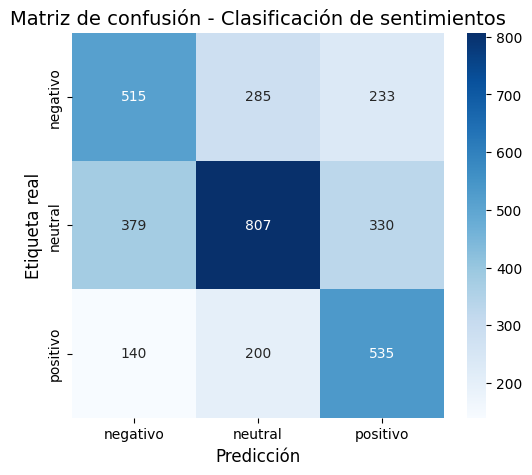

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=pipe.named_steps["clf"].classes_)

# Graficar con seaborn
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,        # muestra los números
    fmt='d',           # formato entero
    cmap='Blues',      # color azul
    xticklabels=pipe.named_steps["clf"].classes_,  # etiquetas eje X
    yticklabels=pipe.named_steps["clf"].classes_   # etiquetas eje Y
)

plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta real', fontsize=12)
plt.title('Matriz de confusión - Clasificación de sentimientos', fontsize=14)
plt.show()


## (2) SVM

A continuación, probamos un clasificador de Máquinas de Vectores de Soporte (SVM), específicamente `LinearSVC`, conocido por su gran eficacia en problemas de clasificación de texto. En este `Pipeline`, en lugar de SVD, utilizamos `SelectKBest` con la prueba `chi2` para la selección de características. Este método elige las 50,000 características (palabras o n-gramas) que tienen la relación estadística más fuerte con las clases de sentimiento, permitiendo que el modelo se enfoque en las señales más relevantes.

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

pipe = Pipeline([
    ("chi2", SelectKBest(chi2, k=50000)),  # prueba 10k/20k/30k según tamaño
    ("svm", LinearSVC(class_weight="balanced", C=1.0, max_iter=10000))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=50000 is greater than n_features=11332. All the features will be returned.
  warnings.warn(


              precision    recall  f1-score   support

    negativo       0.76      0.73      0.74      1033
     neutral       0.76      0.77      0.77      1516
    positivo       0.74      0.76      0.75       875

    accuracy                           0.75      3424
   macro avg       0.75      0.75      0.75      3424
weighted avg       0.75      0.75      0.75      3424



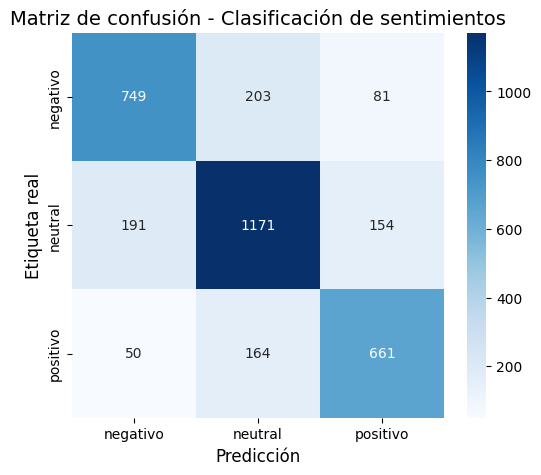

In [ ]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=pipe.named_steps["svm"].classes_)

# Graficar con seaborn
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,        # muestra los números
    fmt='d',           # formato entero
    cmap='Blues',      # color azul
    xticklabels=pipe.named_steps["svm"].classes_,  # etiquetas eje X
    yticklabels=pipe.named_steps["svm"].classes_   # etiquetas eje Y
)

plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta real', fontsize=12)
plt.title('Matriz de confusión - Clasificación de sentimientos', fontsize=14)
plt.show()

##(3) SVM + N-grams

Aquí exploramos el poder de los N-gramas para capturar más contexto. Un n-grama es una secuencia de 'n' ítems (palabras o caracteres). Probamos tres enfoques diferentes, todos con un clasificador SVM:

- **Bi-gramas de palabras:** Considera secuencias de una y dos palabras (ej. "no quiero").

- **Tri-gramas de palabras:** Amplía el contexto a secuencias de hasta tres palabras (ej. "ya no te quiero").

- **N-gramas de caracteres:** Analiza secuencias de 3 a 5 caracteres. Este enfoque es muy robusto frente a errores de tipeo o variaciones morfológicas de las palabras (ej. "querer", "quererte", "quiero").

Al final, analizamos qué n-gramas de caracteres son los más influyentes para cada categoría de sentimiento, dándonos una idea de qué patrones a nivel de sub-palabra aprende el modelo.

bi-grams

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
X_train_text, X_test_text, y_train_, y_test_ = train_test_split(
    df["frase_limpia"], y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
pipe_word = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2),
                              min_df=2, max_df=0.9, sublinear_tf=True)),
    ("svm", LinearSVC(class_weight="balanced", C=1.0, max_iter=5000))
])

pipe_word.fit(X_train_text, y_train_)
y_pred_word = pipe_word.predict(X_test_text)
print(classification_report(y_test_, y_pred_word))

              precision    recall  f1-score   support

    negativo       0.71      0.66      0.68      1033
     neutral       0.73      0.74      0.74      1516
    positivo       0.71      0.74      0.72       875

    accuracy                           0.72      3424
   macro avg       0.72      0.72      0.72      3424
weighted avg       0.72      0.72      0.72      3424



tri-grams

In [ ]:
pipe_word = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,3),        # ← sube a tri-gramas
        min_df=2,
        max_df=0.9,
        sublinear_tf=True,
        max_features=100_000      # ← evita que explote y acelera
    )),
    ("svm", LinearSVC(class_weight="balanced", C=1.0, max_iter=5000))
])

pipe_word.fit(X_train_text, y_train_)
y_pred_word = pipe_word.predict(X_test_text)
print(classification_report(y_test_, y_pred_word))

              precision    recall  f1-score   support

    negativo       0.70      0.66      0.68      1033
     neutral       0.73      0.74      0.74      1516
    positivo       0.72      0.74      0.73       875

    accuracy                           0.72      3424
   macro avg       0.72      0.72      0.72      3424
weighted avg       0.72      0.72      0.72      3424



n-gramas de caracteres

In [ ]:
pipe_char = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(3,5),
        min_df=2,
        sublinear_tf=True,
        max_features=200_000
    )),
    ("svm", LinearSVC(class_weight="balanced", C=2.0, max_iter=5000))
])

pipe_char.fit(X_train_text, y_train_)
y_pred_char = pipe_char.predict(X_test_text)
print(classification_report(y_test_, y_pred_char))

              precision    recall  f1-score   support

    negativo       0.75      0.75      0.75      1033
     neutral       0.77      0.77      0.77      1516
    positivo       0.75      0.76      0.75       875

    accuracy                           0.76      3424
   macro avg       0.76      0.76      0.76      3424
weighted avg       0.76      0.76      0.76      3424



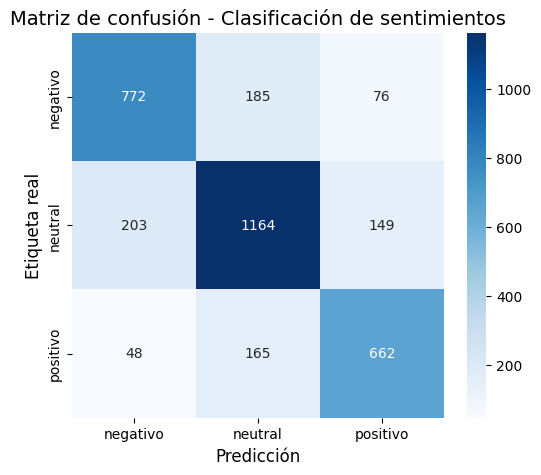

In [ ]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test_, y_pred_char, labels=pipe_char.named_steps["svm"].classes_)

# Graficar con seaborn
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,        # muestra los números
    fmt='d',           # formato entero
    cmap='Blues',      # color azul
    xticklabels=pipe_char.named_steps["svm"].classes_,  # etiquetas eje X
    yticklabels=pipe_char.named_steps["svm"].classes_   # etiquetas eje Y
)

plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta real', fontsize=12)
plt.title('Matriz de confusión - Clasificación de sentimientos', fontsize=14)
plt.show()

In [ ]:
def top_ngrams_por_clase_char(pipeline, k=20):
    """Muestra los n-gramas de caracteres con mayor peso para cada clase."""
    vec = pipeline.named_steps["tfidf"]
    clf = pipeline.named_steps["svm"]
    clases = clf.classes_
    feature_names = np.array(vec.get_feature_names_out())
    coefs = clf.coef_  # pesos del clasificador

    resultados = {}

    for i, clase in enumerate(clases):
        idx = np.argsort(coefs[i])[-k:][::-1]  # top-k más positivos
        top_feats = list(zip(feature_names[idx], coefs[i][idx]))
        resultados[clase] = top_feats

    return resultados


# === Usar con tu modelo entrenado ===
tops = top_ngrams_por_clase_char(pipe_char, k=20)

for clase, lista in tops.items():
    print(f"\n=== Clase: {clase} ===")
    for ng, peso in lista:
        print(f"{ng!r}\t{peso:.4f}")



=== Clase: negativo ===
'mal'	2.5827
'o mal'	2.1479
'ios v'	2.0867
'aca'	1.9811
'ido d'	1.9545
'e rea'	1.9458
'dej'	1.9446
'ieren'	1.9037
'pero '	1.8443
'ro pa'	1.8240
'ngra'	1.8128
'é vid'	1.8047
' na '	1.7871
'dol'	1.7552
'tris'	1.7521
'trist'	1.7521
'vas s'	1.7495
'sta m'	1.7409
'fal'	1.7355
'ía ca'	1.7191

=== Clase: neutral ===
'ores '	1.8724
'evi'	1.7978
'par'	1.7809
'nza a'	1.7796
'rado '	1.7605
'ien m'	1.7359
'des e'	1.7295
' dos'	1.7292
'si '	1.6815
'fro q'	1.6163
'no a'	1.5898
'a x'	1.5757
'y vid'	1.5556
'ido b'	1.5100
'ke '	1.5059
'iero '	1.5013
's pre'	1.5011
'r vo'	1.4867
'sito '	1.4865
'cen a'	1.4853

=== Clase: positivo ===
'amo'	2.4753
'ido n'	2.4728
'mas n'	2.3392
'es va'	2.0448
'gos s'	1.8863
'bell'	1.8530
'da i'	1.8188
'rtant'	1.8147
'sos a'	1.8125
'ca de'	1.7923
'rdo a'	1.7722
'a muj'	1.7518
'bes'	1.7394
'flor '	1.7331
'igo s'	1.7221
' am'	1.7005
'do n'	1.6942
'ero m'	1.6787
'suela'	1.6751
'ntart'	1.6726


## (4) Naive Bayes

Ahora implementamos un clasificador Naive Bayes, un algoritmo probabilístico basado en el teorema de Bayes que es tradicionalmente rápido y efectivo para la clasificación de texto. Específicamente, usamos `ComplementNB`, una variante del Naive Bayes Multinomial que está especialmente diseñada para funcionar bien con conjuntos de datos desbalanceados, corrigiendo algunas de las suposiciones del modelo estándar para mejorar el rendimiento en clases minoritarias.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB(alpha=0.5)  # o prueba [0.5,1,2]
cnb.fit(X_train, y_train)
y_pred_cnb = cnb.predict(X_test)

print("=== Complement NB ===")
print(classification_report(y_test, y_pred_cnb))

=== Complement NB ===
              precision    recall  f1-score   support

    negativo       0.70      0.74      0.72      1033
     neutral       0.79      0.68      0.73      1516
    positivo       0.66      0.79      0.72       875

    accuracy                           0.72      3424
   macro avg       0.72      0.73      0.72      3424
weighted avg       0.73      0.72      0.72      3424



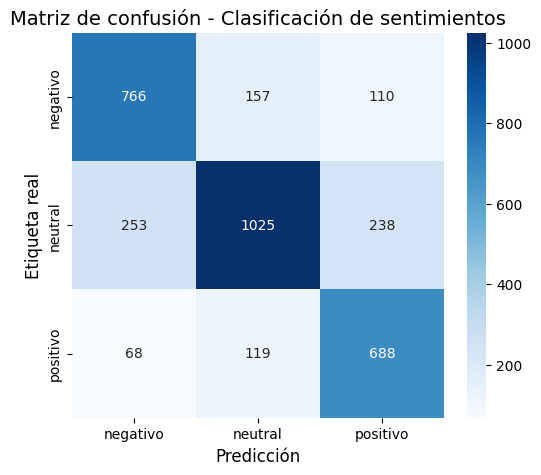

In [ ]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred_cnb, labels=cnb.classes_)

# Graficar con seaborn
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,        # muestra los números
    fmt='d',           # formato entero
    cmap='Blues',      # color azul
    xticklabels=cnb.classes_,  # etiquetas eje X
    yticklabels=cnb.classes_   # etiquetas eje Y
)

plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta real', fontsize=12)
plt.title('Matriz de confusión - Clasificación de sentimientos', fontsize=14)
plt.show()

## (5) RF

Este algoritmo construye múltiples árboles de decisión durante el entrenamiento y combina sus predicciones para obtener una clasificación final más precisa y robusta. Al igual que con la Regresión Logística, lo integramos en un `Pipeline` con `TruncatedSVD` para reducir la dimensionalidad de los datos antes de alimentar al bosque, lo que ayuda a que cada árbol se entrene con las características más significativas.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ("svd", TruncatedSVD(n_components=200, random_state=42)),  # 100–300 va bien
    ("norm", Normalizer(copy=False)),
    ("rf", RandomForestClassifier(
        n_estimators=100,           # baja a 100 para velocidad
        max_depth=20,              # limita profundidad
        min_samples_leaf=3,        # evita sobreajuste y reduce nodos
        max_features="sqrt",       # menos atributos por split
        bootstrap=False,           # más rápido que bootstrap=True
        n_jobs=-1,
        random_state=42
    ))
])

pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
print("=== RF con SVD (200) ===")
print(classification_report(y_test, y_pred_rf))

=== RF con SVD (200) ===
              precision    recall  f1-score   support

    negativo       0.78      0.60      0.68      1033
     neutral       0.67      0.86      0.76      1516
    positivo       0.78      0.60      0.68       875

    accuracy                           0.72      3424
   macro avg       0.74      0.69      0.71      3424
weighted avg       0.73      0.72      0.71      3424



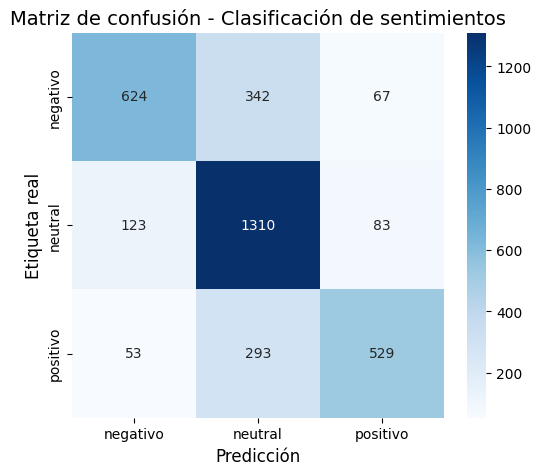

In [ ]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf, labels=cnb.classes_)

# Graficar con seaborn
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,        # muestra los números
    fmt='d',           # formato entero
    cmap='Blues',      # color azul
    xticklabels=cnb.classes_,  # etiquetas eje X
    yticklabels=cnb.classes_   # etiquetas eje Y
)

plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta real', fontsize=12)
plt.title('Matriz de confusión - Clasificación de sentimientos', fontsize=14)
plt.show()

## (6) MLP

Finalmente, damos un paso hacia el deep learning con un Perceptrón Multicapa (MLP). Se trata de una red neuronal artificial con varias capas densamente conectadas, capaz de aprender patrones mucho más complejos y no lineales en los datos. Nuestra arquitectura incluye capas ocultas con activación `ReLU` y capas de `Dropout` para prevenir el sobreajuste. La capa final utiliza una activación `softmax` para producir una distribución de probabilidad sobre las diferentes clases de sentimiento.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Codificar etiquetas
enc = LabelEncoder()
y_train_enc = enc.fit_transform(y_train)
y_test_enc = enc.transform(y_test)

In [ ]:
# Crear red MLP
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(enc.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train.toarray(), y_train_enc,
                    validation_split=0.1, epochs=10, batch_size=64, verbose=1)

loss, acc = model.evaluate(X_test.toarray(), y_test_enc)
print(f"Accuracy test: {acc:.3f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.4878 - loss: 0.9928 - val_accuracy: 0.7124 - val_loss: 0.6808
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.8358 - loss: 0.4354 - val_accuracy: 0.7314 - val_loss: 0.6422
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.9071 - loss: 0.2530 - val_accuracy: 0.7380 - val_loss: 0.7332
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9374 - loss: 0.1792 - val_accuracy: 0.7401 - val_loss: 0.8245
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.9469 - loss: 0.1373 - val_accuracy: 0.7423 - val_loss: 0.8949
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9550 - loss: 0.1169 - val_accuracy: 0.7350 - val_loss: 0.9591
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.9619 - loss: 0.1016 - val_accuracy: 0.7219 - val_loss: 1.0159
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.9649 - loss: 0.0887 -

In [ ]:
type(X_test), type(X_train)

(scipy.sparse._csr.csr_matrix, scipy.sparse._csr.csr_matrix)

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
=== Reporte de Clasificación - MLP ===
              precision    recall  f1-score   support

    negativo       0.75      0.68      0.71      1033
     neutral       0.72      0.78      0.75      1516
    positivo       0.72      0.70      0.71       875

    accuracy                           0.73      3424
   macro avg       0.73      0.72      0.72      3424
weighted avg       0.73      0.73      0.73      3424



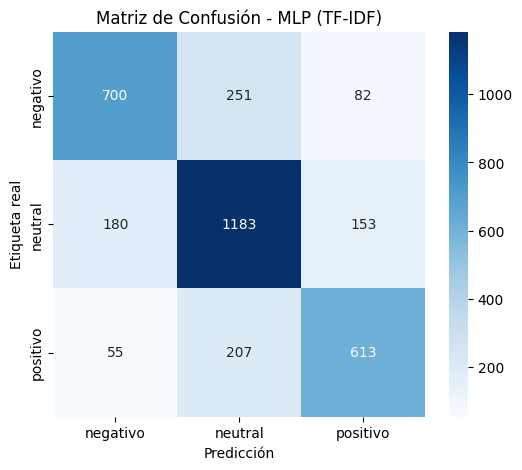

In [ ]:
# Predicciones
y_pred_probs = model.predict(X_test.toarray())
y_pred = np.argmax(y_pred_probs, axis=1)

# Reporte de clasificación
print("=== Reporte de Clasificación - MLP ===")
print(classification_report(y_test_enc, y_pred, target_names=enc.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=enc.classes_, yticklabels=enc.classes_)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión - MLP (TF-IDF)')
plt.show()